# gdsfactory in 5 minutes

## Layout

gdsfactory easily enables you to layout Component with as many levels of hierarchy as you need.

A `Component` is a canvas where we can add polygons, references to other components or ports.

Lets add two references in a component.

2023-01-22 16:13:24.342 | INFO     | gdsfactory.config:<module>:50 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 6.23.4


2023-01-22 16:13:25.164 | INFO     | gdsfactory.technology.layer_views:__init__:779 - Importing LayerViews from KLayout layer properties file: /home/runner/work/gdsfactory/gdsfactory/gdsfactory/generic_tech/klayout/tech/layers.lyp.


/home/runner/work/gdsfactory/gdsfactory/gdsfactory/component.py:1522: UserWarning: Component 'Unnamed_4b351d5d' contains 1 Unnamed cells
  warnings.warn(


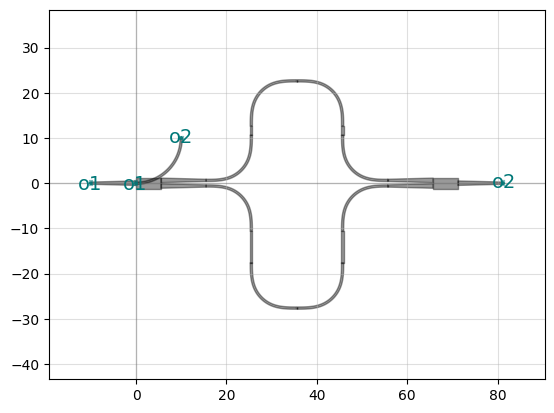

Unnamed_4b351d5d: uid 4b351d5d, ports [], references ['mzi_1', 'bend_circular_1'], 0 polygons

In [1]:
from typing import Optional

import toolz
from omegaconf import OmegaConf

import gdsfactory as gf
from gdsfactory.component import Component
from gdsfactory.components.bend_euler import bend_euler
from gdsfactory.components.coupler90 import coupler90 as coupler90function
from gdsfactory.components.coupler_straight import (
    coupler_straight as coupler_straight_function,
)
from gdsfactory.components.straight import straight
from gdsfactory.cross_section import strip
from gdsfactory.snap import assert_on_2nm_grid
from gdsfactory.types import ComponentSpec, CrossSectionSpec

c = gf.Component()
mzi = c << gf.components.mzi()  # equivalent to mzi = c.add_ref(gf.components.mzi())
bend = (
    c << gf.components.bend_circular()
)  # equivalent to bend = c.add_ref(gf.components.bend_circular())
c

You can connect the bend `o1` port to the mzi `o2` port.

/home/runner/work/gdsfactory/gdsfactory/gdsfactory/component.py:1522: UserWarning: Component 'Unnamed_e979f0c1' contains 1 Unnamed cells
  warnings.warn(


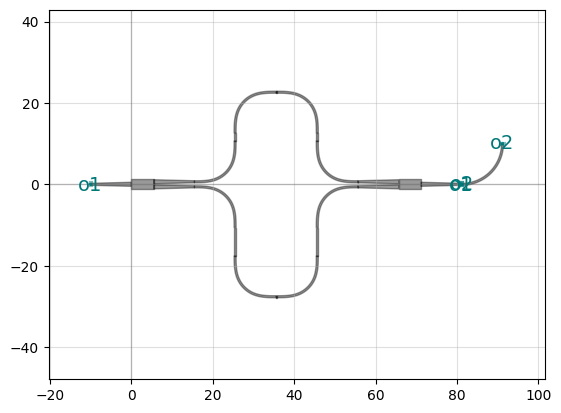

Unnamed_e979f0c1: uid e979f0c1, ports [], references ['mzi_1', 'bend_circular_1'], 0 polygons

In [2]:
c = gf.Component()
mzi = c << gf.components.mzi()  # equivalent to mzi = c.add_ref(gf.components.mzi())
bend = (
    c << gf.components.bend_circular()
)  # equivalent to bend = c.add_ref(gf.components.bend_circular())
bend.connect("o1", mzi.ports["o2"])
c

You can also define a `cell` function that returns a parametric Component depending on the arguments you pass and gets automatic name.

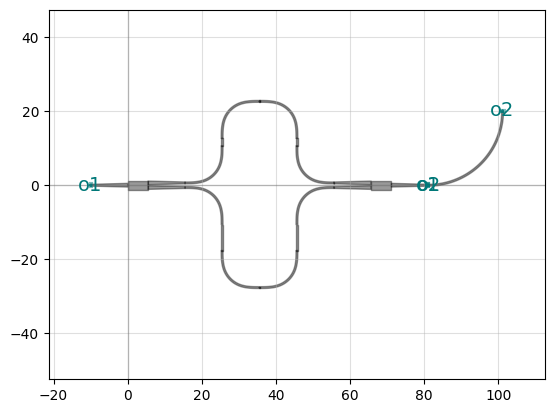

mzi_with_bend_radius20: uid deeb3918, ports [], references ['mzi_1', 'bend_circular_1'], 0 polygons

In [3]:
@gf.cell
def mzi_with_bend(radius: float = 10):
    c = gf.Component()
    mzi = c << gf.components.mzi()  # equivalent to mzi = c.add_ref(gf.components.mzi())
    bend = c << gf.components.bend_circular(
        radius=radius
    )  # equivalent to bend = c.add_ref(gf.components.bend_circular())
    bend.connect("o1", mzi.ports["o2"])
    return c


c = mzi_with_bend(radius=20)
c

Now to connect your component to other components you need to add ports.

In [4]:
c.ports

{}

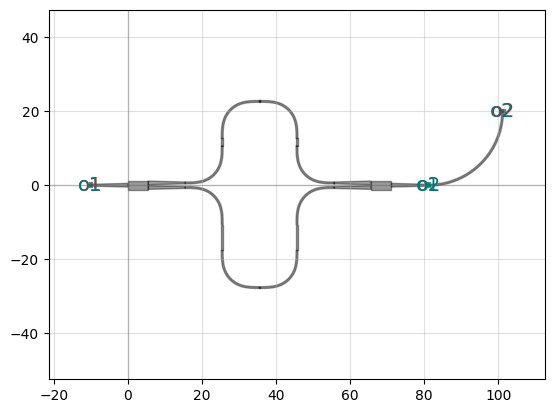

mzi_with_bend_radius20: uid 5cfd3ff1, ports ['o1', 'o2'], references ['mzi_1', 'bend_circular_1'], 0 polygons

In [5]:
@gf.cell
def mzi_with_bend(radius: float = 10):
    c = gf.Component()
    mzi = c << gf.components.mzi()  # equivalent to mzi = c.add_ref(gf.components.mzi())
    bend = c << gf.components.bend_circular(
        radius=radius
    )  # equivalent to bend = c.add_ref(gf.components.bend_circular())
    bend.connect("o1", mzi.ports["o2"])
    c.add_port("o1", port=mzi.ports["o1"])
    c.add_port("o2", port=bend.ports["o2"])
    return c


c = mzi_with_bend(
    radius=20, cache=False
)  # as we changed the code inside the function you need to clear the cache from the cell decorator.
c

In [6]:
c.ports

{'o1': Port (name o1, center [-10.   0.], width 0.5, orientation 180.0, layer (1, 0), port_type optical),
 'o2': Port (name o2, center [101.2  20. ], width 0.5, orientation 90.0, layer (1, 0), port_type optical)}

Once you have ports you can route it to fiber couplers.

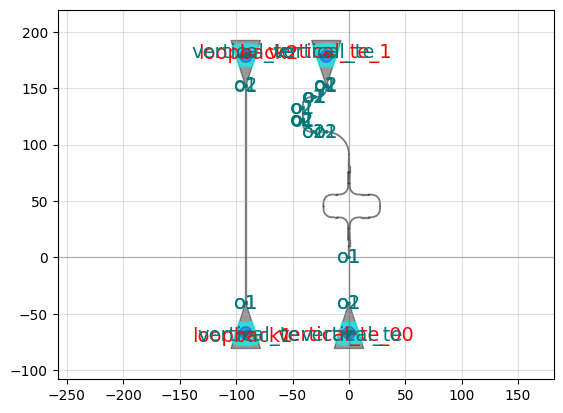

mzi_with_bend_radius20__5e9cb656: uid 3cf95445, ports ['vertical_te_00', 'vertical_te_1', 'loopback1', 'loopback2'], references ['move_1', 'straight_1', 'bend_euler_1', 'straight_2', 'straight_3', 'bend_euler_2', 'bend_euler_3', 'straight_4', 'straight_5', 'straight_6', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'straight_7', 'grating_coupler_elliptical_trenches_3', 'grating_coupler_elliptical_trenches_4'], 0 polygons

In [7]:
c_fiber_single = gf.routing.add_fiber_single(c)
c_fiber_single

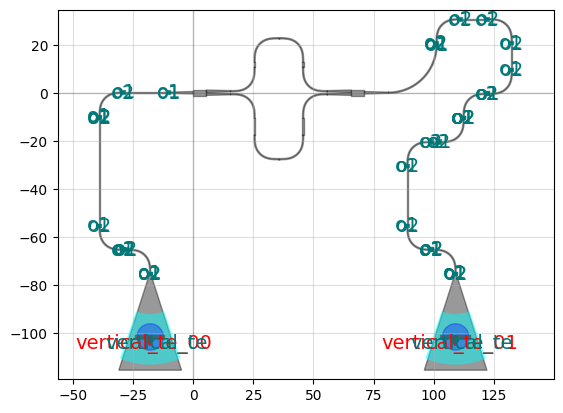

mzi_with_bend_radius20__12469c7c: uid d3335799, ports ['vertical_te_00', 'vertical_te_01'], references ['bend_euler_1', 'straight_1', 'straight_2', 'bend_euler_2', 'bend_euler_3', 'bend_euler_4', 'bend_euler_5', 'straight_3', 'straight_4', 'straight_5', 'straight_6', 'straight_7', 'bend_euler_6', 'bend_euler_7', 'straight_8', 'straight_9', 'straight_10', 'bend_euler_8', 'bend_euler_9', 'bend_euler_10', 'bend_euler_11', 'straight_11', 'straight_12', 'straight_13', 'straight_14', 'straight_15', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'mzi_with_bend_1'], 0 polygons

In [8]:
c_fiber_array = gf.routing.add_fiber_array(c, with_loopback=False)
c_fiber_array

In [9]:
scene = c_fiber_array.to_3d()
scene.show()

For a component it's important that you spend some time early to parametrize it correctly. Don't be afraid to spend some time using pen and paper and choosing easy to understand names.

Lets for example define a ring resonator, which is already a circuit made of waveguides, bends and couplers.

Components, circuits and Masks are made in Parametric `cell` functions, that can also accept other ComponentSpec.

A Component Spec can be:

- a parametric cell function (decorated with `cell`)
- a string. To get a cell registered in the active pdk.
- a dict. `dict(component='mmi2x2', length_mmi=3)`

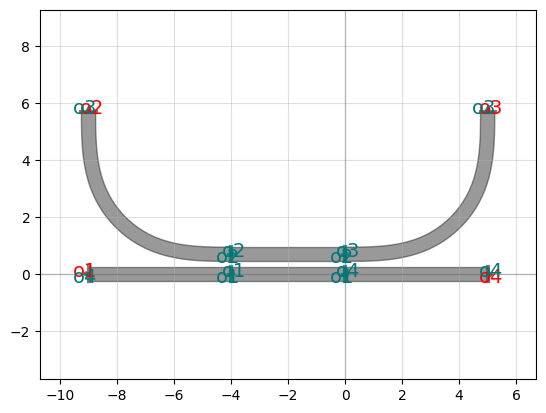

coupler_ring: uid 6b1938cd, ports ['o2', 'o1', 'o3', 'o4'], references ['coupler90_1', 'coupler90_2', 'coupler_straight_1'], 0 polygons

In [10]:
@gf.cell
def coupler_ring(
    gap: float = 0.2,
    radius: float = 5.0,
    length_x: float = 4.0,
    coupler90: ComponentSpec = coupler90function,
    bend: Optional[ComponentSpec] = None,
    coupler_straight: ComponentSpec = coupler_straight_function,
    cross_section: CrossSectionSpec = strip,
    bend_cross_section: Optional[CrossSectionSpec] = None,
    **kwargs,
) -> Component:
    r"""Coupler for ring.

    Args:
        gap: spacing between parallel coupled straight waveguides.
        radius: of the bends.
        length_x: length of the parallel coupled straight waveguides.
        coupler90: straight coupled to a 90deg bend.
        bend: bend spec.
        coupler_straight: two parallel coupled straight waveguides.
        cross_section: cross_section spec.
        bend_cross_section: optional bend cross_section spec.
        kwargs: cross_section settings for bend and coupler.

    .. code::

           2             3
           |             |
            \           /
             \         /
           ---=========---
         1    length_x    4


    """
    bend = bend or bend_euler

    c = Component()
    assert_on_2nm_grid(gap)

    # define subcells
    coupler90_component = gf.get_component(
        coupler90,
        gap=gap,
        radius=radius,
        bend=bend,
        cross_section=cross_section,
        bend_cross_section=bend_cross_section,
        **kwargs,
    )
    coupler_straight_component = gf.get_component(
        coupler_straight,
        gap=gap,
        length=length_x,
        cross_section=cross_section,
        **kwargs,
    )

    # add references to subcells
    cbl = c << coupler90_component
    cbr = c << coupler90_component
    cs = c << coupler_straight_component

    # connect references
    y = coupler90_component.y
    cs.connect(port="o4", destination=cbr.ports["o1"])
    cbl.mirror(p1=(0, y), p2=(1, y))
    cbl.connect(port="o2", destination=cs.ports["o2"])

    c.add_port("o1", port=cbl.ports["o3"])
    c.add_port("o2", port=cbl.ports["o4"])
    c.add_port("o3", port=cbr.ports["o3"])
    c.add_port("o4", port=cbr.ports["o4"])
    c.auto_rename_ports()
    return c


coupler = coupler_ring()
coupler

Lets define a ring function that also accepts other component specs for the subcomponents (straight, coupler, bend)

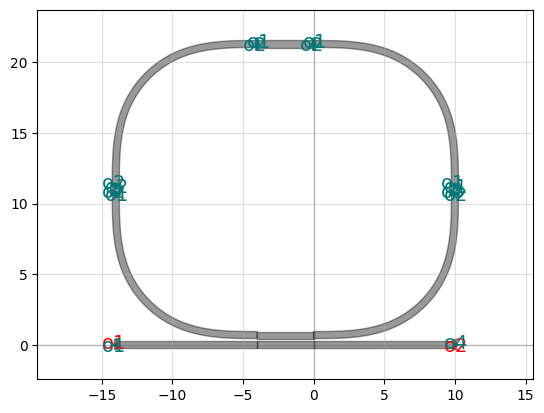

ring_single: uid 5077d45f, ports ['o2', 'o1'], references ['coupler_ring_1', 'straight_1', 'straight_2', 'bend_euler_1', 'bend_euler_2', 'straight_3'], 0 polygons

In [11]:
@gf.cell
def ring_single(
    gap: float = 0.2,
    radius: float = 10.0,
    length_x: float = 4.0,
    length_y: float = 0.6,
    coupler_ring: ComponentSpec = coupler_ring,
    bend: ComponentSpec = bend_euler,
    cross_section: ComponentSpec = "strip",
    **kwargs,
) -> gf.Component:
    """Returns a single ring.

    ring coupler (cb: bottom) connects to two vertical straights (sl: left, sr: right),
    two bends (bl, br) and horizontal straight (wg: top)

    Args:
        gap: gap between for coupler.
        radius: for the bend and coupler.
        length_x: ring coupler length.
        length_y: vertical straight length.
        coupler_ring: ring coupler spec.
        bend: 90 degrees bend spec.
        cross_section: cross_section spec.
        kwargs: cross_section settings


    .. code::

          bl-st-br
          |      |
          sl     sr length_y
          |      |
         --==cb==-- gap

          length_x

    """
    gf.snap.assert_on_2nm_grid(gap)

    c = gf.Component()
    cb = c << gf.get_component(
        coupler_ring,
        bend=bend,
        gap=gap,
        radius=radius,
        length_x=length_x,
        cross_section=cross_section,
        **kwargs,
    )
    sy = gf.get_component(
        straight, length=length_y, cross_section=cross_section, **kwargs
    )
    b = gf.get_component(bend, cross_section=cross_section, radius=radius, **kwargs)
    sx = straight(length=length_x, cross_section=cross_section, **kwargs)
    sl = c << sy
    sr = c << sy
    bl = c << b
    br = c << b
    st = c << sx

    sl.connect(port="o1", destination=cb.ports["o2"])
    bl.connect(port="o2", destination=sl.ports["o2"])

    st.connect(port="o2", destination=bl.ports["o1"])
    br.connect(port="o2", destination=st.ports["o1"])
    sr.connect(port="o1", destination=br.ports["o1"])
    sr.connect(port="o2", destination=cb.ports["o3"])

    c.add_port("o2", port=cb.ports["o4"])
    c.add_port("o1", port=cb.ports["o1"])
    return c


ring = ring_single()
ring

How do you customize components?

You can use `functools.partial` to customize the default settings from any component

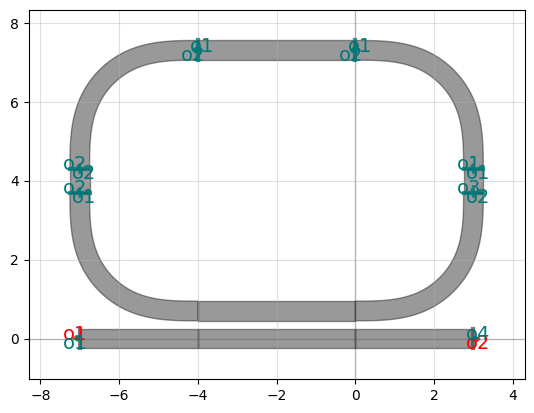

ring_single_radius3: uid fcf5e675, ports ['o2', 'o1'], references ['coupler_ring_1', 'straight_1', 'straight_2', 'bend_euler_1', 'bend_euler_2', 'straight_3'], 0 polygons

In [12]:
ring_single3 = gf.partial(ring_single, radius=3)
ring_single3()

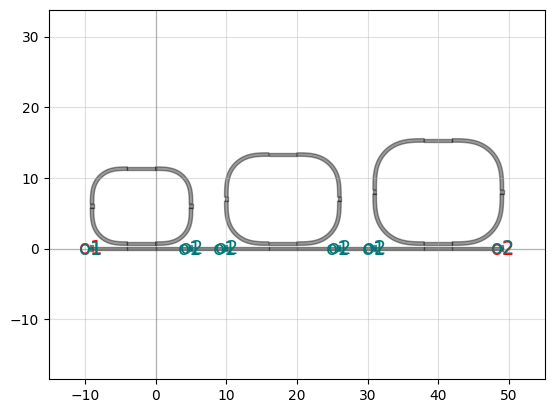

ring_single_array_d7816013: uid a520a04f, ports ['o1', 'o2'], references ['ring_single_1', 'ring_single_2', 'straight_1', 'ring_single_3', 'straight_2'], 0 polygons

In [13]:
ring_array = gf.components.ring_single_array(
    list_of_dicts=[dict(radius=i) for i in [5, 6, 7]]
)
ring_array

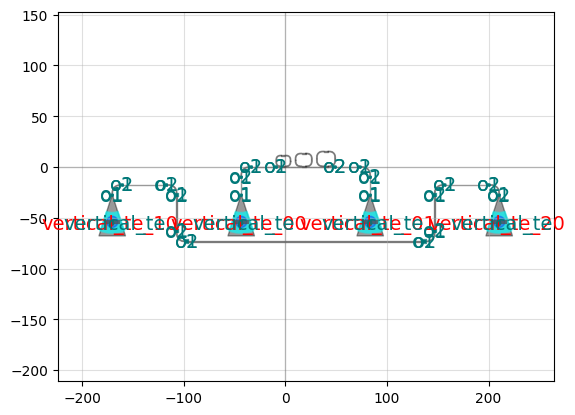

ring_single_array_d7816_0ca9371f: uid ad6dda61, ports ['vertical_te_00', 'vertical_te_01', 'vertical_te_10', 'vertical_te_20'], references ['bend_euler_1', 'straight_1', 'straight_2', 'bend_euler_2', 'straight_3', 'straight_4', 'bend_euler_3', 'bend_euler_4', 'bend_euler_5', 'bend_euler_6', 'bend_euler_7', 'bend_euler_8', 'straight_5', 'straight_6', 'straight_7', 'straight_8', 'straight_9', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'grating_coupler_elliptical_trenches_3', 'grating_coupler_elliptical_trenches_4', 'ring_single_array_1'], 0 polygons

In [14]:
ring_with_grating_couplers = gf.routing.add_fiber_array(ring_array)
ring_with_grating_couplers

## Netlist driven flow

You can define components as a Place and Route netlist.

- instances
- placements
- routes

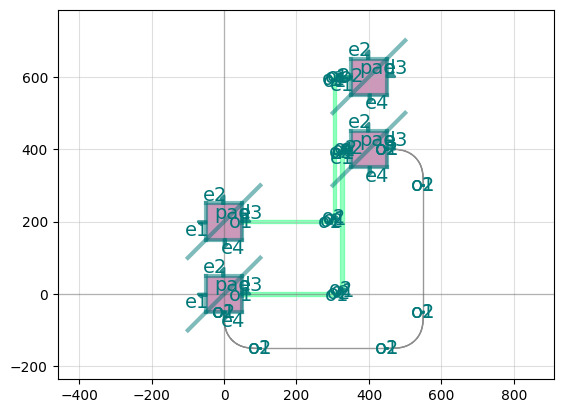

sample_different_factor_0124aeb5: uid c9959508, ports [], references ['bl', 'tl', 'br', 'tr', 'bend_euler_1', 'bend_euler_2', 'straight_1', 'straight_2', 'straight_3', 'bend_euler_3', 'bend_euler_4', 'straight_4', 'straight_5', 'straight_6', 'bend_euler_5', 'bend_euler_6', 'bend_euler_7', 'straight_7', 'straight_8', 'straight_9', 'straight_10'], 0 polygons

In [15]:
yaml = """
name: sample_different_factory

instances:
    bl:
      component: pad
    tl:
      component: pad
    br:
      component: pad
    tr:
      component: pad

placements:
    tl:
        x: 0
        y: 200

    br:
        x: 400
        y: 400

    tr:
        x: 400
        y: 600


routes:
    electrical:
        settings:
            separation: 20
            layer: [41, 0]
            width: 10
        links:
            tl,e3: tr,e1
            bl,e3: br,e1
    optical:
        settings:
            radius: 100
        links:
            bl,e4: br,e3

"""

mzi = gf.read.from_yaml(yaml)
mzi

## Top reticle assembly

Once you have your components and circuits defined, you can add them into a top reticle Component for fabrication.

You need to consider:

- what design variations do you want to include in the mask? You need to define your Design Of Experiment or DOE
- obey DRC (Design rule checking) foundry rules for manufacturability. Foundry usually provides those rules for each layer (min width, min space, min density, max density)
- make sure you will be able to test te devices after fabrication. Obey DFT (design for testing) rules. For example, if your test setup works only for fiber array, what is the fiber array spacing (127 or 250um?)
- if you plan to package your device, make sure you follow your packaging guidelines from your packaging house (min pad size, min pad pitch, max number of rows for wire bonding ...)

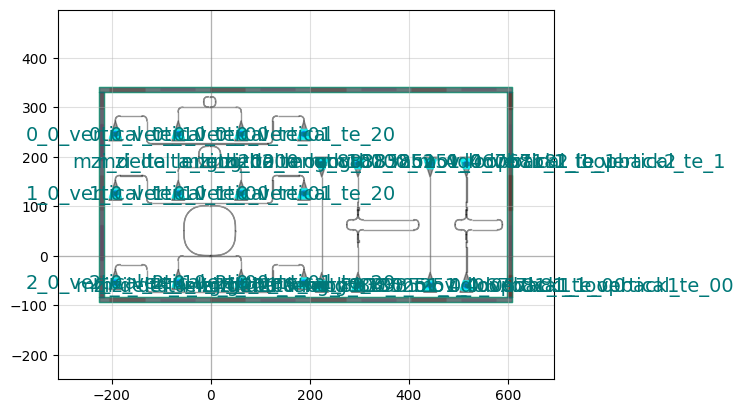

reticle: uid 2c9f932b, ports [], references ['grid_1', 'pack_doe_1', 'seal_ring_1'], 0 polygons

In [16]:
ring_te = toolz.compose(gf.routing.add_fiber_array, gf.components.ring_single)
rings = gf.grid([ring_te(radius=r) for r in [10, 20, 50]])


@gf.cell
def reticle(size=(1000, 1000)):
    c = gf.Component()
    r = c << rings
    m = c << gf.components.pack_doe(
        gf.components.mzi,
        settings=dict(delta_length=[100, 200]),
        function=gf.routing.add_fiber_single,
    )
    m.xmin = r.xmax + 10
    m.ymin = r.ymin
    c << gf.components.seal_ring(c.bbox)
    return c


m = reticle(cache=False)
m

In [17]:
gdspath = m.write_gds_with_metadata(gdspath="mask.gds")

2023-01-22 16:13:30.793 | INFO     | gdsfactory.component:_write_library:1538 - Wrote to 'mask.gds'


2023-01-22 16:13:31.288 | INFO     | gdsfactory.component:write_gds_with_metadata:1623 - Write YAML metadata to 'mask.yml'


Make sure you save the GDS with metadata so when the chip comes back you remember what you have on it.

You can also save the labels for automatic testing.

In [18]:
labels_path = gdspath.with_suffix(".csv")
gf.labels.write_labels.write_labels_klayout(gdspath=gdspath, layer_label=(66, 0))

2023-01-22 16:13:31.395 | INFO     | gdsfactory.labels.write_labels:write_labels_klayout:95 - Wrote 12 labels to CSV /home/runner/work/gdsfactory/gdsfactory/docs/notebooks/mask.csv


PosixPath('mask.csv')

In [19]:
mask_metadata = OmegaConf.load(gdspath.with_suffix(".yml"))
tm = gf.labels.merge_test_metadata(mask_metadata=mask_metadata, labels_path=labels_path)

In [20]:
tm.keys()

dict_keys(['ring_single_radius10', 'ring_single_radius20', 'ring_single_radius50'])